# Bài tập 4: Phân cụm đa cấp trên dữ liệu Online Retail
Dataset: https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

## 1. Import thư viện và load dữ liệu

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Load dữ liệu
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
print("Thông tin dữ liệu:")
df.info()
print(f"\nSố dòng: {len(df)}")

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Số dòng: 541909


## 2. Làm sạch dữ liệu

In [5]:
# Loại bỏ null và các giao dịch không hợp lệ
df = df[df['CustomerID'].notna()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

print(f"Số dòng sau khi làm sạch: {len(df)}")

Số dòng sau khi làm sạch: 397884


## 3. Tạo đặc trưng RFM

In [6]:
# Tính TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Ngày tham chiếu
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Tạo bảng RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("Bảng RFM:")
print(rfm.head())
print("\nThống kê:")
print(rfm.describe())

Bảng RFM:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

Thống kê:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


## 4. Xử lý outliers và chuẩn hóa

In [7]:
# Loại bỏ outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

rfm_clean = remove_outliers(rfm, ['Recency', 'Frequency', 'Monetary'])
print(f"Số khách hàng sau khi loại outliers: {len(rfm_clean)}")

# Chuẩn hóa
X = rfm_clean[['Recency', 'Frequency', 'Monetary']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Shape: {X_scaled.shape}")

Số khách hàng sau khi loại outliers: 3602
Shape: (3602, 3)


## 5. Tính linkage matrix và vẽ Dendrogram

In [8]:
# Lấy mẫu nhỏ để vẽ dendrogram (nếu dữ liệu quá lớn)
sample_size = min(500, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Tính linkage matrix
linkage_matrix = linkage(X_sample, method='ward', metric='euclidean')

print(f"Đã tính linkage matrix cho {sample_size} mẫu")

Đã tính linkage matrix cho 500 mẫu


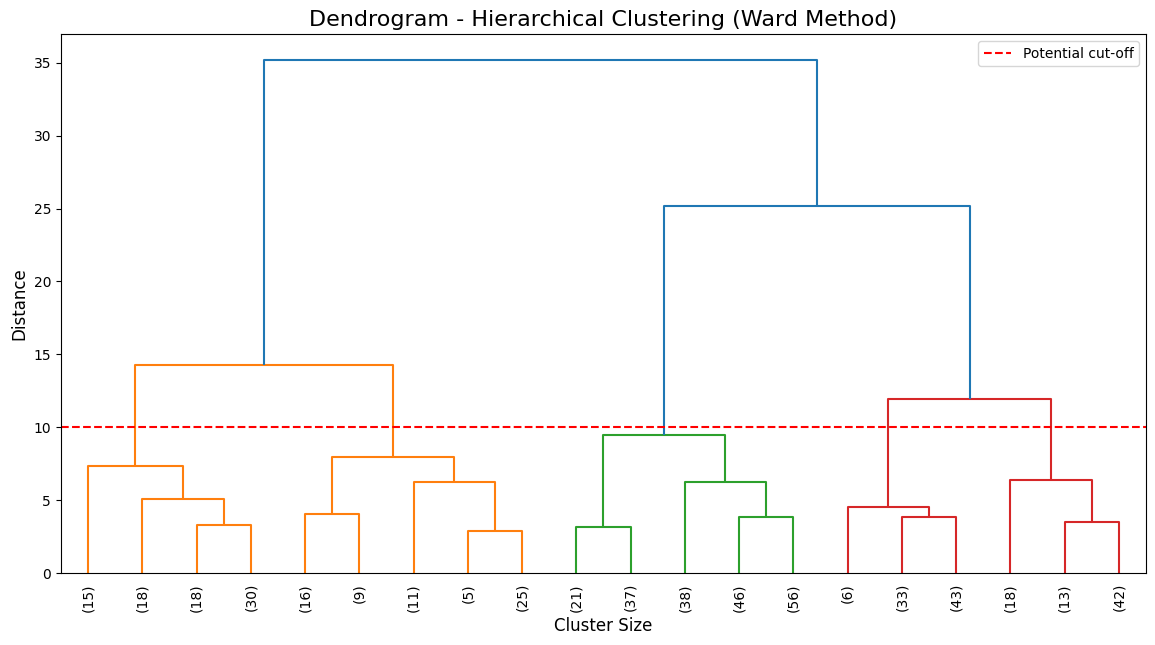

In [9]:
# Vẽ dendrogram truncated
plt.figure(figsize=(14, 7))
plt.title('Dendrogram - Hierarchical Clustering (Ward Method)', fontsize=16)
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.xlabel('Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=10, color='r', linestyle='--', label='Potential cut-off')
plt.legend()
plt.show()

## 6. So sánh các phương pháp linkage

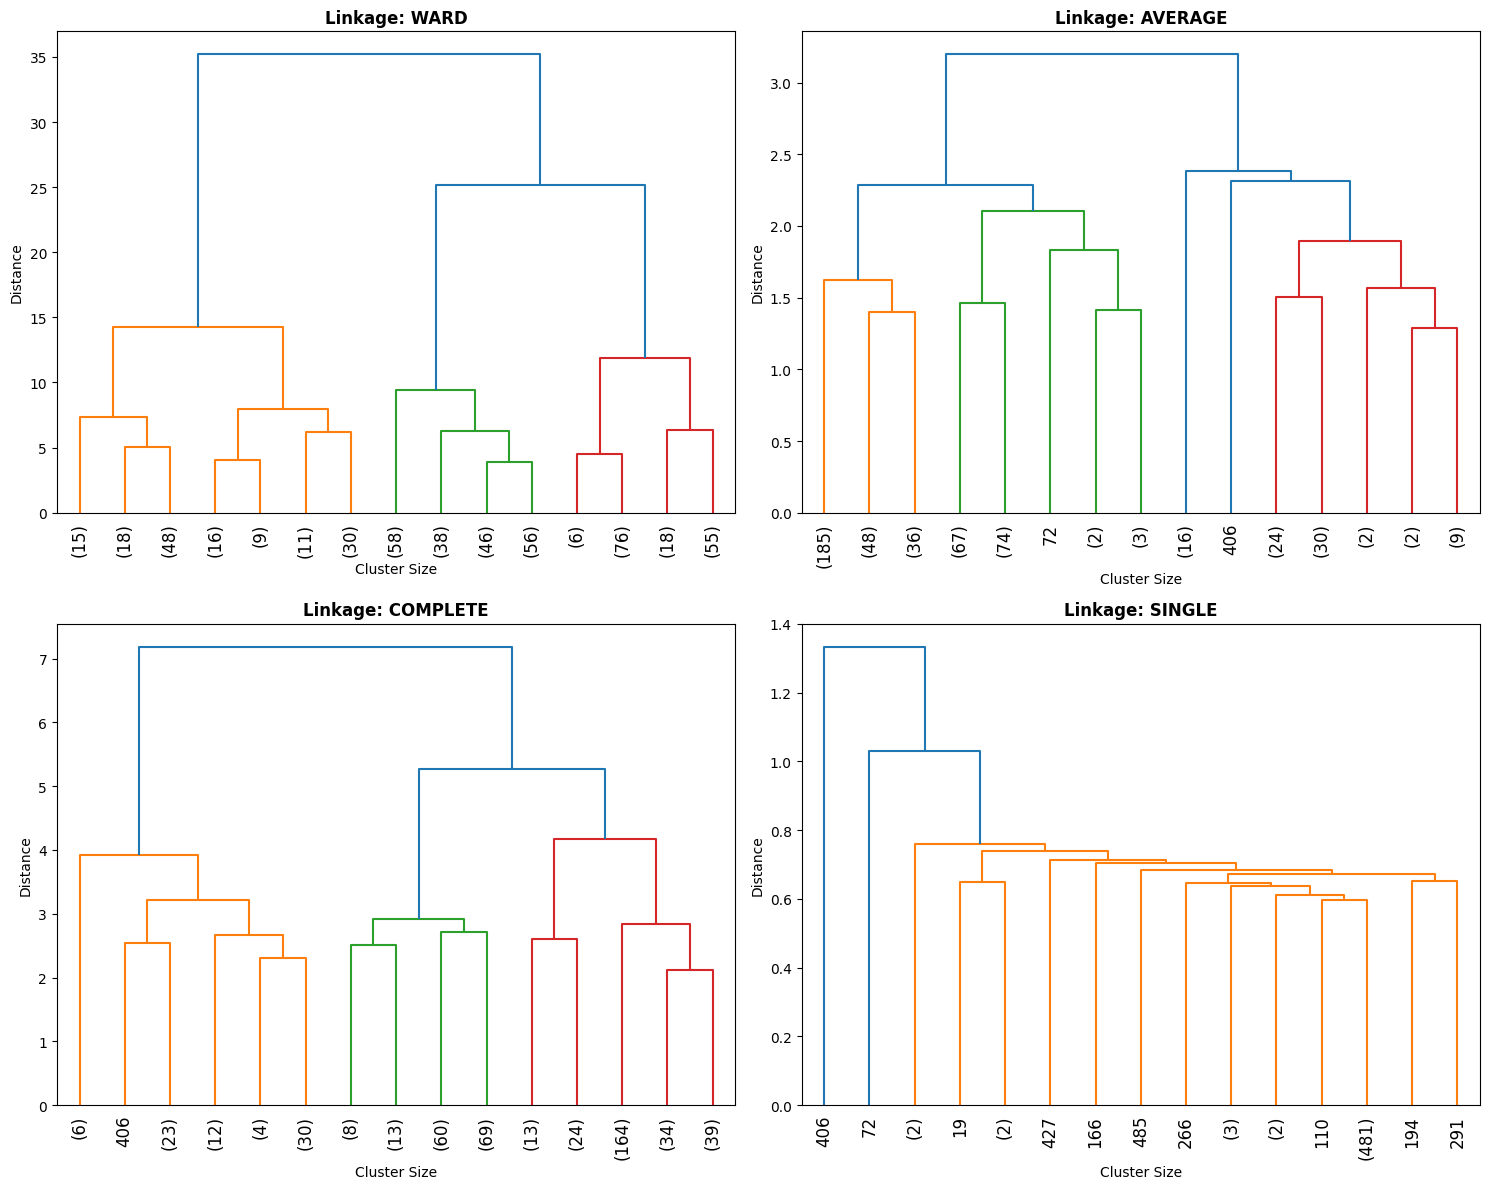

In [10]:
# So sánh các phương pháp linkage
methods = ['ward', 'average', 'complete', 'single']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, method in enumerate(methods):
    linkage_mat = linkage(X_sample, method=method, metric='euclidean')
    
    dendrogram(
        linkage_mat,
        ax=axes[idx],
        truncate_mode='lastp',
        p=15,
        show_leaf_counts=True,
        leaf_rotation=90
    )
    axes[idx].set_title(f'Linkage: {method.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster Size')
    axes[idx].set_ylabel('Distance')

plt.tight_layout()
plt.show()

## 7. Tìm số cụm tối ưu

K=2, Silhouette Score=0.4608
K=3, Silhouette Score=0.4217
K=4, Silhouette Score=0.3303
K=5, Silhouette Score=0.3178
K=6, Silhouette Score=0.3284
K=7, Silhouette Score=0.2897
K=8, Silhouette Score=0.2638
K=9, Silhouette Score=0.2743
K=10, Silhouette Score=0.2720


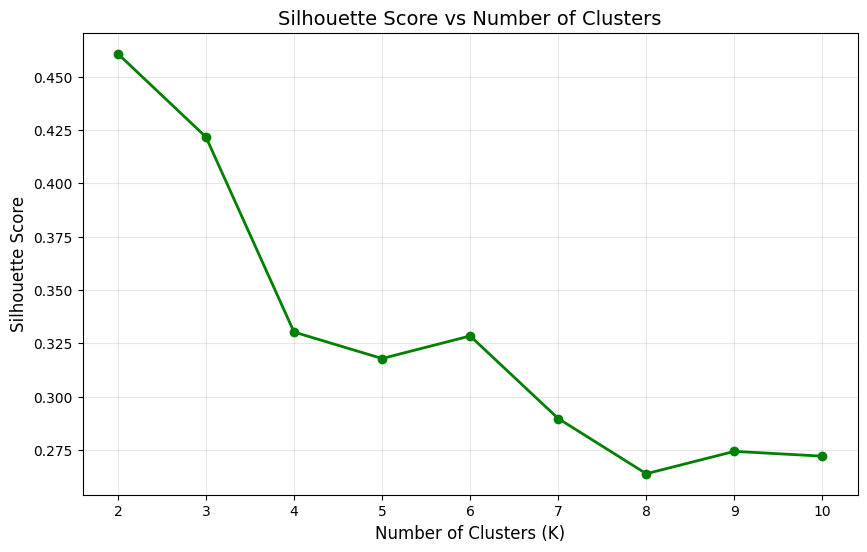


Số cụm tối ưu: K = 2


In [11]:
# Tính silhouette score cho các giá trị k
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', linewidth=2, color='green')
plt.title('Silhouette Score vs Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu: K = {optimal_k}")

## 8. Xây dựng mô hình với Sklearn

In [12]:
# Agglomerative Clustering với scikit-learn
optimal_k = 4
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
sklearn_clusters = agg_clustering.fit_predict(X_scaled)

rfm_clean['Cluster_Hierarchical'] = sklearn_clusters

print(f"Silhouette Score: {silhouette_score(X_scaled, sklearn_clusters):.4f}")
print(f"\nPhân bố các cụm:")
print(rfm_clean['Cluster_Hierarchical'].value_counts().sort_index())

Silhouette Score: 0.3303

Phân bố các cụm:
Cluster_Hierarchical
0     727
1     947
2    1029
3     899
Name: count, dtype: int64


## 9. So sánh với K-Means

In [13]:
# K-Means với cùng số cụm
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(X_scaled)
rfm_clean['Cluster_KMeans'] = kmeans_clusters

# So sánh Silhouette Score
print("\nSo sánh Silhouette Score:")
print(f"Hierarchical Clustering: {silhouette_score(X_scaled, sklearn_clusters):.4f}")
print(f"K-Means Clustering: {silhouette_score(X_scaled, kmeans_clusters):.4f}")

# Crosstab
print("\nBảng so sánh phân bố:")
comparison = pd.crosstab(
    rfm_clean['Cluster_Hierarchical'], 
    rfm_clean['Cluster_KMeans'],
    rownames=['Hierarchical'],
    colnames=['K-Means']
)
print(comparison)


So sánh Silhouette Score:
Hierarchical Clustering: 0.3303
K-Means Clustering: 0.4093

Bảng so sánh phân bố:
K-Means         0    1    2    3
Hierarchical                    
0               0  265    6  456
1             359  588    0    0
2             156    7  866    0
3             899    0    0    0


## 10. Phân tích đặc điểm các cụm

In [14]:
# Thống kê chi tiết cho từng cụm (Hierarchical)
cluster_summary = rfm_clean.groupby('Cluster_Hierarchical').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std'],
    'CustomerID': 'count'
}).round(2)

print("\nĐặc điểm của các cụm (Hierarchical Clustering):")
print(cluster_summary)


Đặc điểm của các cụm (Hierarchical Clustering):
                     Recency               Frequency              Monetary  \
                        mean median    std      mean median   std     mean   
Cluster_Hierarchical                                                         
0                      36.69   23.0  43.29      5.97    6.0  1.95  1871.01   
1                      46.56   36.0  36.14      2.84    3.0  0.94   941.57   
2                     213.77  213.0  62.68      1.49    1.0  0.83   393.71   
3                      43.72   40.0  27.28      1.39    1.0  0.58   302.92   

                                      CustomerID  
                       median     std      count  
Cluster_Hierarchical                              
0                     1859.16  618.78        727  
1                      864.86  378.81        947  
2                      312.38  296.68       1029  
3                      293.10  158.49        899  


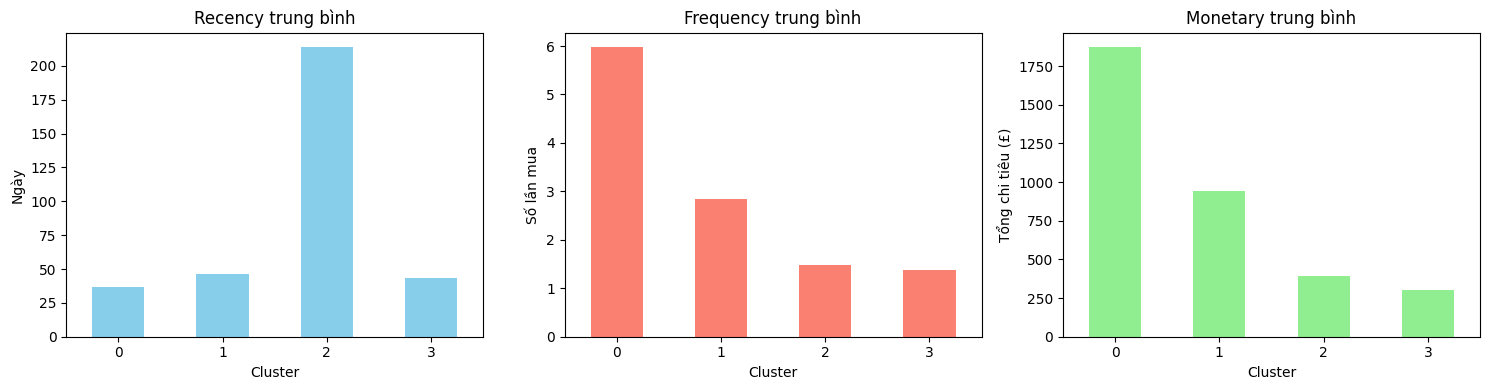

In [15]:
# Visualize đặc điểm trung bình
cluster_avg = rfm_clean.groupby('Cluster_Hierarchical')[['Recency', 'Frequency', 'Monetary']].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cluster_avg['Recency'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Recency trung bình', fontsize=12)
axes[0].set_ylabel('Ngày')
axes[0].set_xlabel('Cluster')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

cluster_avg['Frequency'].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Frequency trung bình', fontsize=12)
axes[1].set_ylabel('Số lần mua')
axes[1].set_xlabel('Cluster')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

cluster_avg['Monetary'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Monetary trung bình', fontsize=12)
axes[2].set_ylabel('Tổng chi tiêu (£)')
axes[2].set_xlabel('Cluster')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## 11. Trực quan hóa các cụm

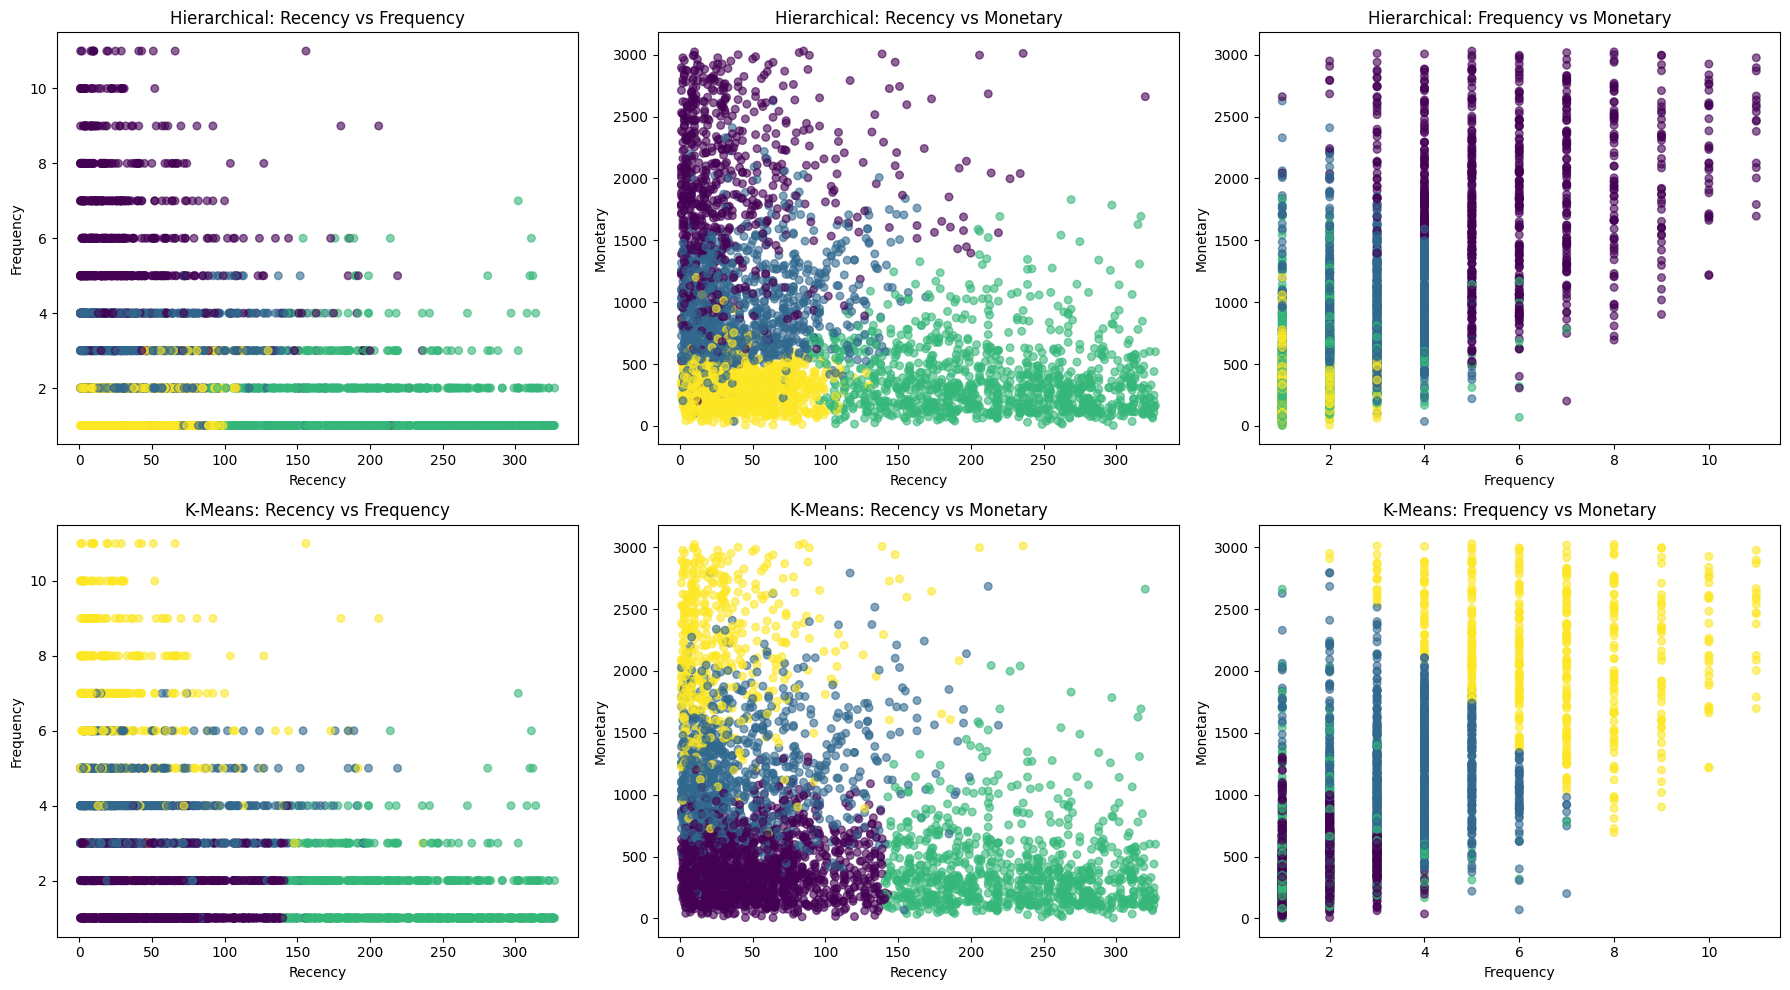

In [16]:
# Scatter plots cho các cặp features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Hierarchical
axes[0, 0].scatter(rfm_clean['Recency'], rfm_clean['Frequency'], 
                   c=rfm_clean['Cluster_Hierarchical'], cmap='viridis', s=30, alpha=0.6)
axes[0, 0].set_title('Hierarchical: Recency vs Frequency')
axes[0, 0].set_xlabel('Recency')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].scatter(rfm_clean['Recency'], rfm_clean['Monetary'], 
                   c=rfm_clean['Cluster_Hierarchical'], cmap='viridis', s=30, alpha=0.6)
axes[0, 1].set_title('Hierarchical: Recency vs Monetary')
axes[0, 1].set_xlabel('Recency')
axes[0, 1].set_ylabel('Monetary')

axes[0, 2].scatter(rfm_clean['Frequency'], rfm_clean['Monetary'], 
                   c=rfm_clean['Cluster_Hierarchical'], cmap='viridis', s=30, alpha=0.6)
axes[0, 2].set_title('Hierarchical: Frequency vs Monetary')
axes[0, 2].set_xlabel('Frequency')
axes[0, 2].set_ylabel('Monetary')

# K-Means
axes[1, 0].scatter(rfm_clean['Recency'], rfm_clean['Frequency'], 
                   c=rfm_clean['Cluster_KMeans'], cmap='viridis', s=30, alpha=0.6)
axes[1, 0].set_title('K-Means: Recency vs Frequency')
axes[1, 0].set_xlabel('Recency')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].scatter(rfm_clean['Recency'], rfm_clean['Monetary'], 
                   c=rfm_clean['Cluster_KMeans'], cmap='viridis', s=30, alpha=0.6)
axes[1, 1].set_title('K-Means: Recency vs Monetary')
axes[1, 1].set_xlabel('Recency')
axes[1, 1].set_ylabel('Monetary')

axes[1, 2].scatter(rfm_clean['Frequency'], rfm_clean['Monetary'], 
                   c=rfm_clean['Cluster_KMeans'], cmap='viridis', s=30, alpha=0.6)
axes[1, 2].set_title('K-Means: Frequency vs Monetary')
axes[1, 2].set_xlabel('Frequency')
axes[1, 2].set_ylabel('Monetary')

plt.tight_layout()
plt.show()

## 12. Gán nhãn cho các nhóm khách hàng


Phân loại khách hàng:
Customer_Segment
At Risk                1846
Lost Customers         1029
Potential Loyalists     727
Name: count, dtype: int64


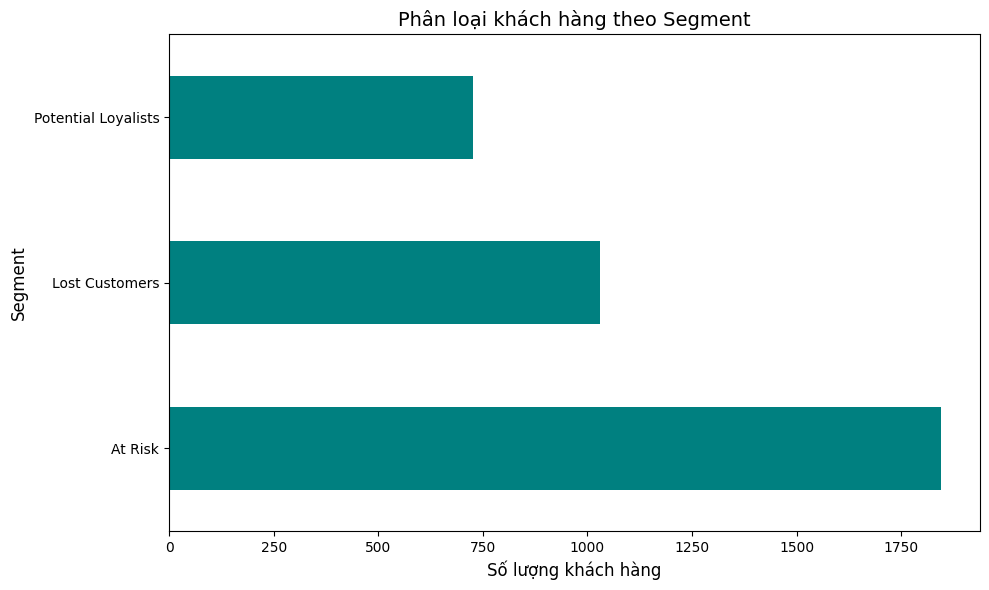

In [17]:
# Phân loại khách hàng dựa trên đặc điểm RFM
def classify_customer(row, cluster_avg):
    cluster_id = row['Cluster_Hierarchical']
    avg = cluster_avg.loc[cluster_id]
    
    if avg['Recency'] < 50 and avg['Frequency'] > 50 and avg['Monetary'] > 3000:
        return 'Champions'
    elif avg['Frequency'] > 30 and avg['Monetary'] > 2000:
        return 'Loyal Customers'
    elif avg['Recency'] < 100 and avg['Monetary'] > 1000:
        return 'Potential Loyalists'
    elif avg['Recency'] > 150:
        return 'Lost Customers'
    else:
        return 'At Risk'

rfm_clean['Customer_Segment'] = rfm_clean.apply(
    lambda row: classify_customer(row, cluster_avg), axis=1
)

print("\nPhân loại khách hàng:")
print(rfm_clean['Customer_Segment'].value_counts())

# Visualize
plt.figure(figsize=(10, 6))
rfm_clean['Customer_Segment'].value_counts().plot(kind='barh', color='teal')
plt.title('Phân loại khách hàng theo Segment', fontsize=14)
plt.xlabel('Số lượng khách hàng', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.tight_layout()
plt.show()

## 13. Kết luận và đề xuất

In [18]:
# Tổng kết phân tích
print("\n" + "="*70)
print("KẾT LUẬN PHÂN TÍCH")
print("="*70)

for cluster_id in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster_Hierarchical'] == cluster_id]
    print(f"\nCLUSTER {cluster_id}:")
    print(f"  - Số khách hàng: {len(cluster_data)}")
    print(f"  - Recency TB: {cluster_data['Recency'].mean():.1f} ngày")
    print(f"  - Frequency TB: {cluster_data['Frequency'].mean():.1f} lần")
    print(f"  - Monetary TB: £{cluster_data['Monetary'].mean():.2f}")
    
    if len(cluster_data) > 0:
        segment = cluster_data['Customer_Segment'].mode()[0]
        print(f"  - Segment chính: {segment}")

print("\n" + "="*70)


KẾT LUẬN PHÂN TÍCH

CLUSTER 0:
  - Số khách hàng: 727
  - Recency TB: 36.7 ngày
  - Frequency TB: 6.0 lần
  - Monetary TB: £1871.01
  - Segment chính: Potential Loyalists

CLUSTER 1:
  - Số khách hàng: 947
  - Recency TB: 46.6 ngày
  - Frequency TB: 2.8 lần
  - Monetary TB: £941.57
  - Segment chính: At Risk

CLUSTER 2:
  - Số khách hàng: 1029
  - Recency TB: 213.8 ngày
  - Frequency TB: 1.5 lần
  - Monetary TB: £393.71
  - Segment chính: Lost Customers

CLUSTER 3:
  - Số khách hàng: 899
  - Recency TB: 43.7 ngày
  - Frequency TB: 1.4 lần
  - Monetary TB: £302.92
  - Segment chính: At Risk

